**Welcome**

This notebook is designed to introduce the MFGNN framework, load the provided models, and visualize input/outputs. 

The notebooks `Functions`, `DataGeneration`, `MFGNN`, and `GNN` are direct implementations of the concepts presented here. It is recommended to explore the data presented here, then if the user wants to develop their own training datasets and models, the user should explore `DataGeneration`, `MFGNN`, and `GNN`. 

Note that the necessary parameters for recreating a given model's training dataset are in `Models/{ModelName}/DataGeneration_params`. These parameteres can be used in the `DataGeration` notebook to recreate a given training dataset. 

**Initialize notebook:** 

PATH: Indicate the current directory, including the file locations of the available models 




In [1]:
PATH = '/content/drive/MyDrive/2021_a_final/Github'

In [2]:
Using_Google_Drive = "Yes"  #@param ["Yes", "No"]
if Using_Google_Drive == "Yes" :
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


# Licenses


In [ ]:
#@title ##### GraphNets License { form-width: "50%" }
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

In [ ]:
#@title ##### Modified Notice - MCMB Lab { form-width: "50%" }
# The GraphNets framework has been modified by:
# Multiscale Computational Mechanics and Biomechanics LAB (MCMB Lab)
# Department of Mechanical Engineering and Mechanics
# Drexel University, Philadelphia, Pennsylvania 
# Diroctor: Ahmad Raeisi Najafi (Ph.D.)
# All rights reserved.
# Developer: Nolan Black 10/2020
# Created in: 10/2020
# Last modified in: 12/2020
# ============================================================================

# Load Functions

In [3]:
FUNCTIONS = PATH + '/Functions.ipynb'
%run $FUNCTIONS

Installing Graph Nets library and dependencies:
Output message from command:

     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 411.0 MB 23 kB/s 
     |████████████████████████████████| 665 kB 47.5 MB/s 
     |████████████████████████████████| 2.5 MB 33.9 MB/s 
     |████████████████████████████████| 503 kB 58.7 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 2.9 MB 46.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.9 MB/s 
     |████████████████████████████████| 3.8 MB 46.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7fbd4163aa8b1e5d2443e8526ed7b6febce83d1aab238f6705399ec1c461ef19
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=07fd4cce62b0d443327b80e7b69c29f950a9937fa85010a6434809ff9b2

Tensor Flow Version: 1.15.5
GPU is NOT AVAILABLE


In [4]:
def normalize_input_list_GNN(input_list, input_stats) :

  """ normalize input features using stats from fetch_stats function"""

  node_means, node_stds, edge_means, edge_stds = input_stats
  for input_gt in input_list :
    input_gt.nodes[..., 10:12] = np.divide(np.subtract(input_gt.nodes[..., 10:12],  
                                                      node_means[10:12]), node_stds[10:12]) 
    input_gt.edges[..., 2:5] = np.divide(np.subtract(input_gt.edges[..., 2:5],  
                                                      edge_means[2:5]), edge_stds[2:5])
    input_gt.edges[..., 7:9] = np.divide(np.subtract(input_gt.edges[..., 7:9],  
                                                      edge_means[7:9]), edge_stds[7:9])
  return input_list

def trim_input_GNN(input_list) :
  """
  simplify 1Hot IDs
  USE with FEA Mesh
  Nodes --> 5 attr
  Edges --> 4 attr, used to be 6
  19 nodes: [x, y, 1ux, 1uy, +-1Fx, +-1Fy, rho, 1surf, 1void, 
            1father_node, ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises]
  16 edges: [x, y, del_x, del_y, length, rho_edges, 1void, 
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  """
  new_list = []
  for item in input_list :
    new_nodes = np.concatenate([item.nodes[..., 10:12], item.nodes[..., 2:6]], axis = 1)
    new_edges = np.concatenate([item.edges[..., 7:9], item.edges[..., 2:5]], axis = 1)

    new_item = graphs.GraphsTuple(nodes = new_nodes,
              edges = new_edges,
              globals=item.globals,
              receivers=item.receivers,
              senders=item.senders,
              n_node=item.n_node,
              n_edge=item.n_edge)
    new_list.append(new_item)  
  return new_list

def trim_input_informed_multiscale(input_list) :
  """
  simplify 1Hot IDs
  USE with FEA Mesh
  Nodes --> 5 attr, used to be 8
  Edges --> 4 attr, used to be 6
  19 nodes: [x, y, 1ux, 1uy, +-1Fx, +-1Fy, rho, 1surf, 1void, 
            1father_node, ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises]
  16 edges: [x, y, del_x, del_y, length, rho_edges, 1void, 
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  """
  new_list = []
  for item in input_list :
    new_nodes = np.concatenate([item.nodes[..., 2:6], item.nodes[..., 9:12], item.nodes[..., 14:19]], axis = 1)
    new_edges = np.concatenate([item.edges[..., 2:5], item.edges[..., 7:9], item.edges[..., 11:16]], axis = 1)
    new_item = graphs.GraphsTuple(nodes=new_nodes,
              edges=new_edges,
              globals=item.globals,
              receivers=item.receivers,
              senders=item.senders,
              n_node=item.n_node,
              n_edge=item.n_edge)
    new_list.append(new_item)  
  return new_list

def trim_input_GNN_U(input_list) :
  """
  simplify 1Hot IDs
  USE with FEA Mesh
  Nodes --> 5 attr
  Edges --> 4 attr, used to be 6
  19 nodes: [x, y, 1ux, 1uy, +-1Fx, +-1Fy, rho, 1surf, 1void, 
            1father_node, ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises]
  16 edges: [x, y, del_x, del_y, length, rho_edges, 1void, 
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  """
  new_list = []
  for item in input_list :
    new_nodes = np.concatenate([item.nodes[..., 0:6], item.nodes[..., 10:12]], axis = 1)
    new_edges = np.concatenate([item.edges[..., 0:5], item.edges[..., 7:9] ], axis = 1)

    new_item = graphs.GraphsTuple(nodes = new_nodes,
              edges = new_edges,
              globals=item.globals,
              receivers=item.receivers,
              senders=item.senders,
              n_node=item.n_node,
              n_edge=item.n_edge)
    new_list.append(new_item)  
  return new_list

def normalize_input_list_informed_multiscale(input_list, input_stats) :

  # input_stats = [np.round(i, 12) for i in input_stats]
  node_means, node_stds, edge_means, edge_stds = input_stats

  local_mean_list = []
  local_std_list = []
  new_edge_list = []
  local_edge_mean_list = []
  local_edge_std_list = []
  for input_gt in input_list :
    # USE GLOBAL STATS
    input_gt.nodes[..., 0:2] = np.divide(np.subtract(input_gt.nodes[..., 0:2],  
                                                      node_means[0:2]), node_stds[0:2]) 
    input_gt.edges[..., 0:5] = np.divide(np.subtract(input_gt.edges[..., 0:5],  
                                                      edge_means[0:5]), edge_stds[0:5])

    # COLLECT LOCAL STATS
    father_means = np.mean(input_gt.nodes[..., 10:19], axis = 0)
    father_stds = np.round(np.std(input_gt.nodes[..., 10:19], axis = 0) , 12)
    father_edge_means = np.mean(input_gt.edges[..., 7:16], axis = 0)
    father_edge_stds = np.round(np.std(input_gt.edges[..., 7:16], axis = 0), 12)
    local_mean_list.append(father_means)
    local_std_list.append(father_stds)
    local_edge_mean_list.append(father_edge_means)
    local_edge_std_list.append(father_edge_stds)
    
    # LOCAL NORMALIZATION
    for i in range(len(input_gt.nodes[..., 0])) :
        input_gt.nodes[i, 10:12] = np.divide(np.subtract(input_gt.nodes[i, 10:12],  
                                                          father_means[0:2]), father_stds[0:2]) 
        input_gt.nodes[i, 14:19] = np.divide(np.subtract(input_gt.nodes[i, 14:19],  
                                                          father_means[4:9]), father_stds[4:9]) 

    for i in range(len(input_gt.edges[..., 0])) :
        input_gt.edges[i, 7:9] = np.divide(np.subtract(input_gt.edges[i, 7:9],  
                                                          father_edge_means[0:2]), father_edge_stds[0:2]) 
        input_gt.edges[i, 11:16] = np.divide(np.subtract(input_gt.edges[i, 11:16],  
                                                  father_edge_means[4:9]), father_edge_stds[4:9]) 

  
  return input_list, local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list
  

In [5]:
def create_feed_dict_GNN(index, input_batch_list, sim_batch_list,
                     input_ph, target_ph) :
  """
  !! Noise is still Experimental !!
  creates feed_dict for tf.session
  Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
  Outputs: feed_dict
  """
  input_gt = input_batch_list[index]
  target_gt = sim_batch_list[index]

  feed_dict = {input_ph: input_gt, target_ph: target_gt}

  return feed_dict

def create_feed_dict_MFGNN(index, input_batch_list, sim_batch_list, mean_list, stds_list, edge_mean_list, edge_stds_list, 
                     input_ph, target_ph, means_ph, stds_ph, edge_means_ph, edge_stds_ph) :
    """
    !! Noise is still Experimental !!
    creates feed_dict for tf.session
    Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
    Outputs: feed_dict
    """
    input_gt = input_batch_list[index]
    target_gt = sim_batch_list[index]
    means =  mean_list[index]
    stds =  stds_list[index]
    edge_means =  edge_mean_list[index]
    edge_stds =  edge_stds_list[index]

    feed_dict = {input_ph: input_gt, target_ph: target_gt, means_ph: means, stds_ph: stds, edge_means_ph: edge_means, edge_stds_ph: edge_stds}

    return feed_dict

def norm_01(x, mean, std) :
  ''' 
  0 mean, unit variance
  for use with tf.tensor inputs
  '''
  return tf.math.divide(tf.subtract(x, mean), std)

def inv_norm_01(y, mean, std) :
  ''' 
  Inverse from 0 mean, unit variance
  for use with tf.tensor inputs
  '''
  return tf.math.add(tf.multiply(y, std), mean)

def log10(x) :
  ten = tf.convert_to_tensor(10.0, dtype = tf.float64)
  return tf.math.log(x) / tf.math.log(ten)

def tanh_val(x, mu) :
  k = 1/ 8
  a = 4
  zero = tf.convert_to_tensor(1e-16, dtype = tf.float64)
  return a * tf.math.tanh(  k * log10(zero + tf.math.abs(x / mu)) )

# @tf.function - unnessary to decorate !!
def tf_du(input_op, output_ops) :
  with tf.GradientTape(persistent=True) as g:
    x  = input_op[0]
    # Tape keeps a record of these ops:
    g.watch(x)
    y = output_ops[0]
  du = g.batch_jacobian(y, x)
  return tf.cast(du, tf.float64)

def create_loss_ops_GNN(target_op, output_ops, target_stats) :
  """

  
  18 nodes: [ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises,
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  17 edges: [del_ux, del_uy, final_length, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises,
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  

  """

  node_means, node_stds, edge_means, edge_stds = target_stats

  del_x_norm = norm_01(target_op.edges[..., 0:1], edge_means[0], edge_stds[0])
  del_y_norm = norm_01(target_op.edges[..., 1:2], edge_means[1], edge_stds[1])
  SE_del_x = (output_ops[1][..., 0:1] - del_x_norm)**2
  SE_del_y = (output_ops[1][..., 1:2] - del_y_norm)**2
  SE_del_uur = tf.reduce_mean(SE_del_x) + tf.reduce_mean(SE_del_y) 


  x_norm = norm_01(target_op.nodes[..., 0:1], node_means[0], node_stds[0])
  y_norm = norm_01(target_op.nodes[..., 1:2], node_means[1], node_stds[1])
  SE_x = (output_ops[0][..., 0:1] - x_norm)**2
  SE_y = (output_ops[0][..., 1:2] - y_norm)**2
  SE_uur = tf.reduce_mean(SE_x)  + tf.reduce_mean(SE_y)

  loss_ops = SE_uur + SE_del_uur 
              
  return loss_ops


def create_loss_ops_MFGNN(target_op, output_ops, local_mean, local_std, local_edge_mean, local_edge_std, 
                    target_stats) :
    """
   
    Nodes : [u_x, u_y, P_x, P_y, du11, du12, du21, du22, Sh]
    Edges : [del_length_x, del_length_y, length, delu11, delu12, delu21, delu22, Sh]
    
    stats = [x_mean_tr, x_std_tr, y_mean_tr, y_std_tr,
            du11_mean_tr, du11_std_tr, du12_mean_tr, du12_std_tr, du21_mean_tr, du21_std_tr, 
            du22_mean_tr, du22_std_tr, sh_mean_tr, sh_std_tr]

    """


    x_norm = norm_01(target_op.nodes[..., 0:1], local_mean[0], local_std[0])
    y_norm = norm_01(target_op.nodes[..., 1:2], local_mean[1], local_std[1])
    SE_x = (output_ops[0][..., 0:1] - x_norm)**2
    SE_y = (output_ops[0][..., 1:2] - y_norm)**2
    SE_uur = tf.reduce_mean(SE_x)  + tf.reduce_mean(SE_y)

    del_conv_x_norm = norm_01(target_op.edges[..., 0:1], local_edge_mean[0], local_edge_std[0])
    del_conv_y_norm = norm_01(target_op.edges[..., 1:2], local_edge_mean[1], local_edge_std[1])
    SE_del_conv_x = (output_ops[1][..., 0:1] - del_conv_x_norm)**2
    SE_del_conv_y = (output_ops[1][..., 1:2] - del_conv_y_norm)**2
    SE_del_conv_uur = tf.reduce_mean(SE_del_conv_x) + tf.reduce_mean(SE_del_conv_y) 

    loss_ops = tf.reduce_mean(SE_uur + SE_del_conv_uur)
                
    return loss_ops

In [6]:
def create_batch_feed_dict(index, input_batch_list, sim_batch_list,
                     input_ph_batch, target_ph_batch) :
  """
  !! Noise is still Experimental !!
  creates feed_dict for tf.session
  Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
  Outputs: feed_dict
  """

  input_feed = []
  target_feed = []
  for i in range(len(input_ph_batch)) :
    if i == 0 :
      input_gt = input_batch_list[index]
      target_gt = sim_batch_list[index]
    else :
      random_index = np.random.randint(0, len(input_batch_list))
      input_gt = input_batch_list[random_index]
      target_gt = sim_batch_list[random_index]
    
    input_feed.append(input_gt)
    target_feed.append(target_gt)

  ph_list = input_ph_batch + target_ph_batch
  feed_list = input_feed + target_feed 

  return dict(zip(ph_list, feed_list))

def create_batch_loss_ops(target_ops, output_ops, target_stats):
    """
    For a mini batch of 2 Examples. Averages loss along the batch.
    This function is really inefficient. would be better to concat graphs, but I haven't done that.
    Create supervised loss operations from targets and outputs.
    Args:
    target_op: The simulated nodal displacement tf.Tensor.
    output_op: The list of output graphs from the model (spec'd as nodes).  

    """ 
             
    loss_ops = tf.reduce_mean([create_loss_ops(target_op, output_op, target_stats) 
                              for target_op, output_op in zip(target_ops, output_ops)])
  
    return loss_ops 

In [7]:
def uur_from_edges_GNN(input_gt, model_output, target_stats) :
  """
  returns nodal uur based on the calculated change in edge lengths
  """
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  mod_x = model_output[1][..., 0] * edge_stds[0] + edge_means[0]
  mod_y = model_output[1][..., 1] * edge_stds[1] + edge_means[1] 
  for i in range(0, len(mod_x) , 2) :
    mod_x[i] = (mod_x[i] - mod_x[i+1]) / 2
    mod_x[i+1] = -mod_x[i]
    mod_y[i] = (mod_y[i] - mod_y[i+1]) / 2
    mod_y[i+1] = -mod_y[i]
  
  
  uur = np.zeros((n_node, 2))
  recorded = set()
  boundary = set()
  node_count = np.zeros((n_node, 1))
  for i in range(n_node) :
    # start with BC
    if input_gt.nodes[i, 2] == 1 :
      uur[i,0]= 0.0
      uur[i,1] = 0.0
      boundary.add(i)
      recorded.add(i)
      node_count[i] += 1
      # adjust nodes directly connected to boundary
      for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
        if s == i and r not in recorded and r not in boundary:
          uur[r, 0] = mod_x[e]
          uur[r, 1] = mod_y[e]
          recorded.add(r)
          node_count[r] += 1

  # loop over the rest of the nodes
  while len(recorded) < (n_node) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if s in recorded and r not in recorded :
        uur[r,0] = mod_x[e] + uur[s,0]
        uur[r,1] = mod_y[e] + uur[s,1]
        node_count[r] += 1
        recorded.add(r)

  # avg based on all input edge deltas
  while sum(node_count) < 2*(n_edge) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if (s in boundary and r not in boundary) or (s not in boundary and r not in boundary):
        node_count[r] += 1
        uur[r,0] += (mod_x[e] + uur[s,0])
        uur[r,1] += (mod_y[e] + uur[s,1])
        uur[r, ...] /= 2 
  return uur

def uur_from_edges_MFGNN(input_gt, model_output, target_stats) :
  """
  returns nodal uur based on the calculated change in edge lengths
  """
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  mod_x = model_output[1][..., 0] * edge_stds[0] + edge_means[0]
  mod_y = model_output[1][..., 1] * edge_stds[1] + edge_means[1] 
  for i in range(0, len(mod_x) , 2) :
    mod_x[i] = (mod_x[i] - mod_x[i+1]) / 2
    mod_x[i+1] = -mod_x[i]
    mod_y[i] = (mod_y[i] - mod_y[i+1]) / 2
    mod_y[i+1] = -mod_y[i]
  
  
  uur = np.zeros((n_node, 2))
  recorded = set()
  boundary = set()
  node_count = np.zeros((n_node, 1))
  for i in range(n_node) :
    # start with BC
    if input_gt.nodes[i, 0] == 1 :
      uur[i,0]= 0.0
      uur[i,1] = 0.0
      boundary.add(i)
      recorded.add(i)
      node_count[i] += 1
      # adjust nodes directly connected to boundary
      for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
        if s == i and r not in recorded and r not in boundary:
          uur[r, 0] = mod_x[e]
          uur[r, 1] = mod_y[e]
          recorded.add(r)
          node_count[r] += 1

  # loop over the rest of the nodes
  while len(recorded) < (n_node) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if s in recorded and r not in recorded :
        uur[r,0] = mod_x[e] + uur[s,0]
        uur[r,1] = mod_y[e] + uur[s,1]
        node_count[r] += 1
        recorded.add(r)

  # avg based on all input edge deltas
  while sum(node_count) < 2*(n_edge) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if (s in boundary and r not in boundary) or (s not in boundary and r not in boundary):
        node_count[r] += 1
        uur[r,0] += (mod_x[e] + uur[s,0])
        uur[r,1] += (mod_y[e] + uur[s,1])
        uur[r, ...] /= 2 
  return uur

def uur_from_nodes(input_gt, model_output, target_stats) :
  """ returns uur directly from nodes"""
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  uur_node = np.zeros((n_node, 2))
  uur_node[..., 0] = model_output[0][..., 0] * node_stds[0] + node_means[0]
  uur_node[..., 1] = model_output[0][..., 1] * node_stds[1] + node_means[1] 

  return uur_node
def uur_from_local_nodes(input_gt, model_output, local_mean, local_std) :
  """ returns uur directly from nodes"""
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  uur_node = np.zeros((n_node, 2))
  uur_node[..., 0] = model_output[0][..., 0] * local_std[0] + local_mean[0]
  uur_node[..., 1] = model_output[0][..., 1] * local_std[1] + local_mean[1]

  return uur_node

In [8]:
def recover_system_nodes_edges(type_option, output_sub_graphist, graph_nodes, graph_edges,
                               local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list) :

  """RECOVER NODES, EDGES: 
  Input:
  output_sub_graphist = list of sub_graphs for a given body
  graph_nodes = node_idx from the given body
  graph_edges = edge_idx from the given body

  Shared attributes are averaged
  """
  if type_option == "target" :
    node_size = 18
    edge_size = 17
  if type_option == "input" :
    node_size = 12
    edge_size = 10
  if type_option == "projection" :
    node_size = 2
    edge_size = 2
  if type_option == "model" or type_option == "model_raw" :
    node_size = 2
    edge_size = 2
  if type_option == "loss" :
    node_size = 4
    edge_size = 17

  try :
    input_nodes =  np.concatenate([sub_graph["nodes"] for sub_graph in output_sub_graphist], axis = 0)
  except (AttributeError) :
    input_nodes =  np.concatenate([sub_graph.nodes for sub_graph in output_sub_graphist], axis = 0)   
  except :
    input_nodes =  np.concatenate([sub_graph[0] for sub_graph in output_sub_graphist], axis = 0)
  try :
    input_edges =  np.concatenate([sub_graph["edges"] for sub_graph in output_sub_graphist], axis = 0)
  except (AttributeError) :
    input_edges =  np.concatenate([sub_graph.edges for sub_graph in output_sub_graphist], axis = 0)
  except :
    input_edges =  np.concatenate([sub_graph[1][..., 0:edge_size] for sub_graph in output_sub_graphist], axis = 0)

  
  if type_option == "model" :
    input_nodes =  np.concatenate([sub_graph[0][..., 0:node_size]*(np.concatenate([(1)*std[0:node_size]])) + np.concatenate([mean[0:node_size]*1]) for sub_graph, std, mean in zip(output_sub_graphist, local_std_list, local_mean_list)], axis = 0)
    input_edges =  np.concatenate([(sub_graph[1][..., 0:edge_size]*1*std[0:edge_size] + 1*mean[0:edge_size]) for sub_graph, std, mean in zip(output_sub_graphist, local_edge_std_list, local_edge_mean_list)], axis = 0)
  if type_option == "model_raw" :
    input_nodes =  np.concatenate([sub_graph[0] for sub_graph in output_sub_graphist], axis = 0)
    input_edges =  np.concatenate([sub_graph[1] for sub_graph in output_sub_graphist], axis = 0)
  if type_option == "projection" :
    input_nodes =  np.concatenate([(sub_graph[0][..., 5:7]*std[0:2] + mean[0:2]) for sub_graph, std, mean in zip(output_sub_graphist, local_std_list, local_mean_list)], axis = 0)
    input_edges =  np.concatenate([(sub_graph[1][..., 3:5]*std[0:2] + mean[0:2])for sub_graph, std, mean in zip(output_sub_graphist, local_edge_std_list, local_edge_mean_list)], axis = 0)

  flat_graph_nodes = [item for sublist in graph_nodes for item in sublist]
  return_nodes = np.zeros((len(set(flat_graph_nodes)), node_size)) 
  node_count = np.zeros((len(set(flat_graph_nodes)), 1)) 
  for sub_node_id, node_id in enumerate(flat_graph_nodes) :
    node_count[node_id] += 1
    if node_count[node_id] == 1 :
      return_nodes[node_id, ...] = input_nodes[sub_node_id, ...]
    else : 
      return_nodes[node_id, ...] += input_nodes[sub_node_id, ...]
      return_nodes[node_id, ...] /= 2
  
  flat_graph_edges = [item for sublist in graph_edges for item in sublist]
  return_edges = np.zeros((len(set(flat_graph_edges)), edge_size)) 
  edge_count = np.zeros((len(set(flat_graph_edges)), 1)) 
  for sub_edge_id, edge_id in enumerate(flat_graph_edges) :
    edge_count[edge_id] += 1
    if edge_count[edge_id] == 1 :
      return_edges[edge_id, ...] = input_edges[sub_edge_id, ...]
    else : 
      return_edges[edge_id, ...] += input_edges[sub_edge_id, ...]
      return_edges[edge_id, ...] /= 2
    
  return return_nodes, return_edges

def return_senders_receivers(output_sub_graphist, graph_nodes, graph_edges) :

  input_receivers = []
  input_senders = []
  for sub_graph in range(len(output_sub_graphist)) :
    global_senders = copy.deepcopy(output_sub_graphist[sub_graph]["senders"])
    global_receivers = copy.deepcopy(output_sub_graphist[sub_graph]["receivers"])
    sub_graph_list_keys = graph_nodes[sub_graph]

    for i, val in enumerate(fea_sub_graph_list[sub_graph]["senders"] ) :
      global_senders[i] = sub_graph_list_keys[val]
    for i, val in enumerate(fea_sub_graph_list[sub_graph]["receivers"] ) :
      global_receivers[i] = sub_graph_list_keys[val]

    input_receivers += global_receivers
    input_senders += global_senders

  flat_graph_edges = [item for sublist in graph_edges for item in sublist]
  return_sends = np.zeros((len(set(flat_graph_edges)), )) 
  return_recs = np.zeros((len(set(flat_graph_edges)), )) 
  for sub_edge_id, edge_id in enumerate(flat_graph_edges) :
    return_recs[edge_id] = int(input_receivers[sub_edge_id])
    return_sends[edge_id] = int(input_senders[sub_edge_id])

  return return_recs, return_sends

# Generate Input/Target Using FEA
A 2D rectangular beam subjected to nodal forces is used as an illustrative example.

Generating data.... 
Stat mesh: 8 x 4 || Father mesh: 16 x 8 || Child mesh: 80 x 40 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2) x (-0.5, 0.5)
Projection Error: avg 0.0746, max 4.8559, min -0.4096
Pass:  0.0005386999542381075
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
...Example data ready in 0m 16s...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
...Complete Optimizer ready in 0m 1s...
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/2021_a_final/Github/Models/MFGNN_1/Model_F1/-2000000
...Init ready in 0m 22s


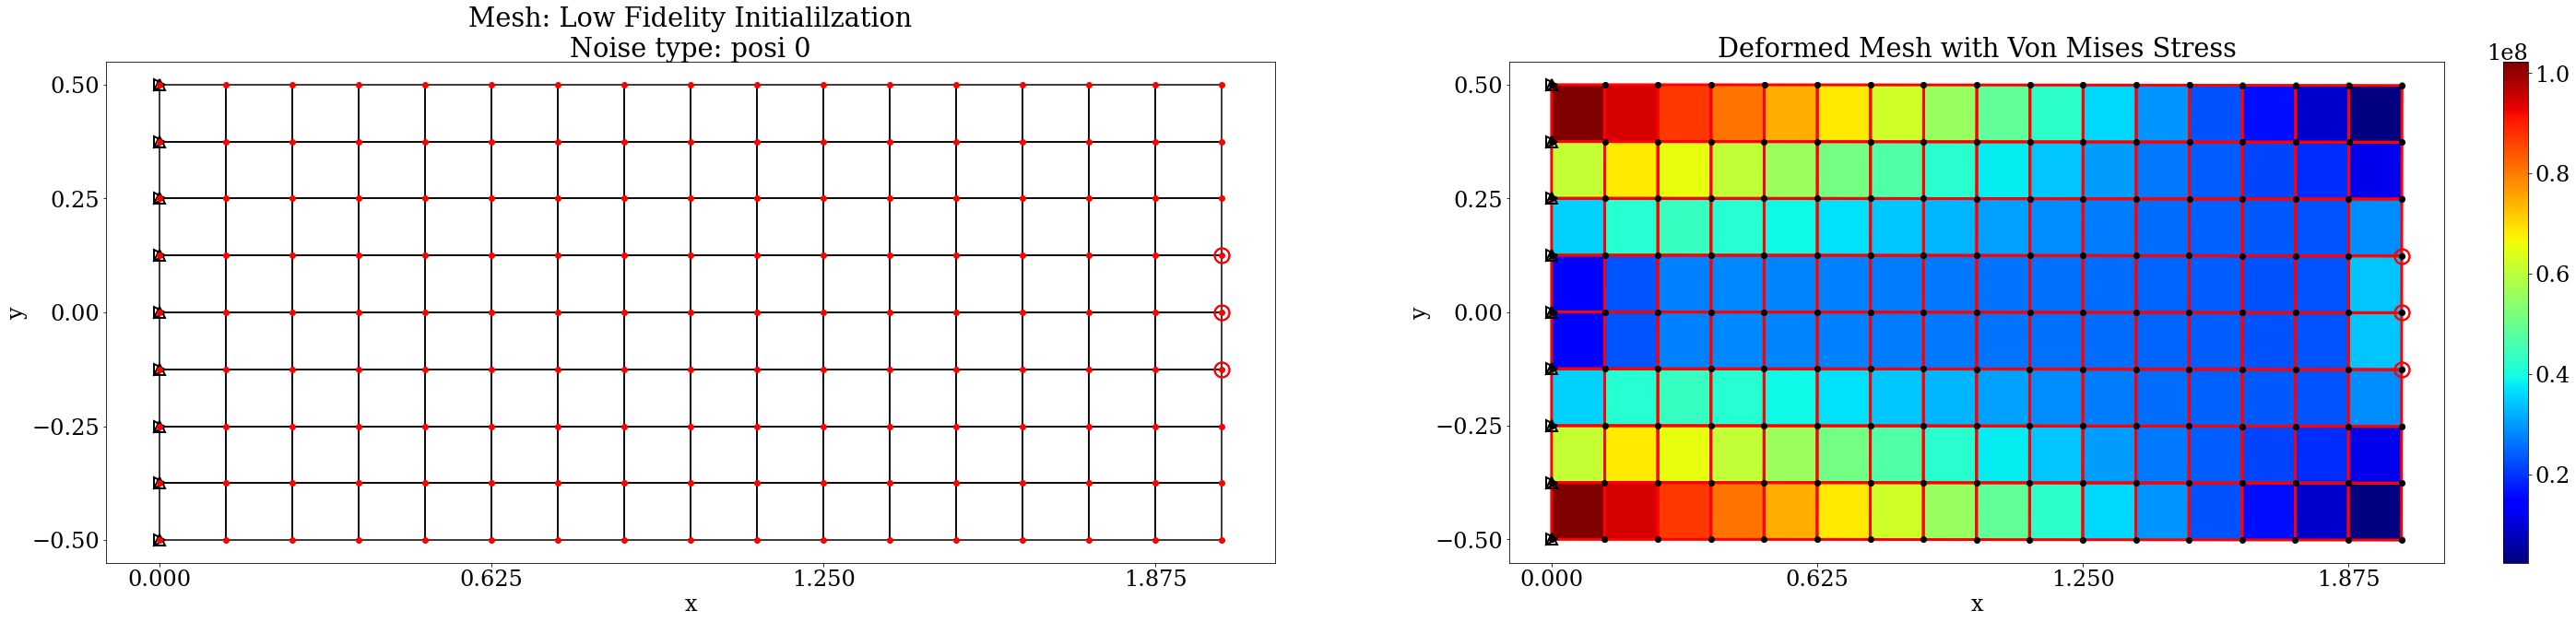

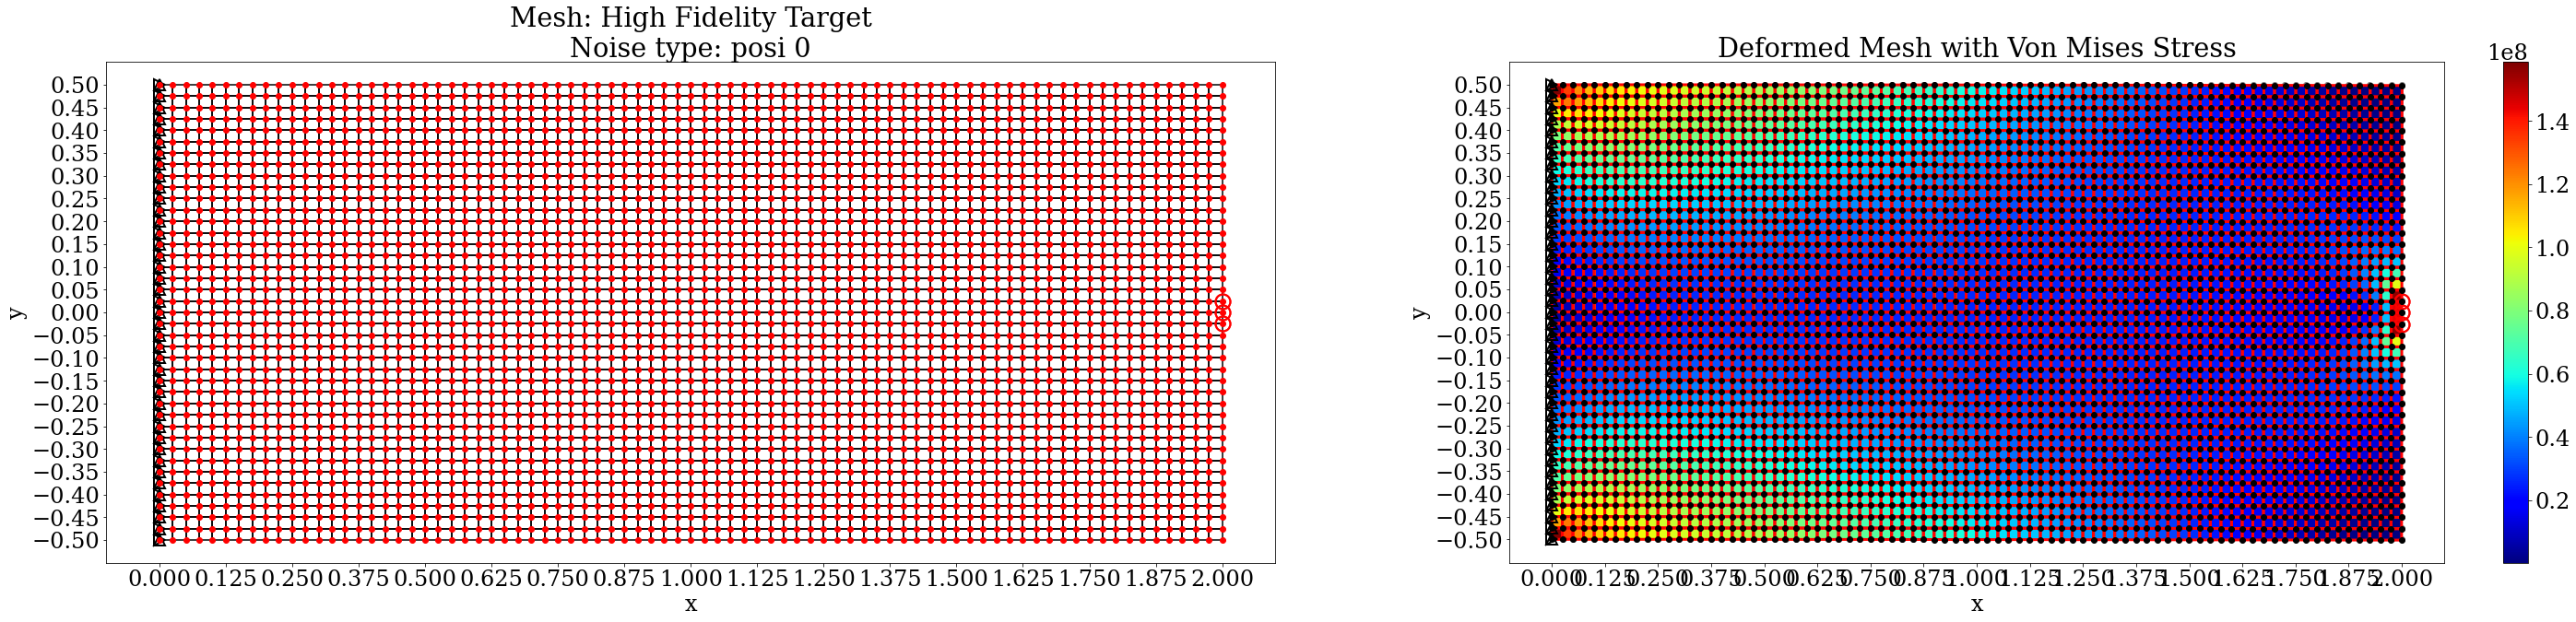

In [9]:
# INIT
from matplotlib import rcParams
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 24}
mpl.rc('font', **font)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']

def visualize_FEA(m1, m2, mesh_coord_noise = 0, title = " " ) :
  """
  Args:
    m1, m2 : Mesh fidelity (i.e., a 12x6 mesh)
    mesh_coord_noise : noise value for coordinate position
    title : plot title

  Outputs:
    Boundary condition plot
    mesh, bc, fea, results data structures containing FEA info
  """
  efficient_opt = True
  mesh = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                    "posi", mesh_coord_noise, 0.0)
  base_density = [1]*mesh.n_elem
  base_material = assign_material(elem_type, mesh, E, v, base_density)
  bc = assign_BC_option(mesh, applied_force_vals, force_dofs, body_force,
                      support, force_location)
  fea = assemble_matrices(elem_type, mesh, base_material, bc, efficient_opt)
  results = solve_FEA(mesh, bc, fea)

  nodal_stress, elem_stress = get_stress_gauss(elem_type, mesh, base_material, results)
  nodal_du, elem_du = get_dU_gauss(elem_type, mesh, results.UUR.T )

  annotations = False
  alternate_title = title + "\nNoise type: " + mesh_noise_type + " " + str(mesh_coord_noise)
  plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
                mesh, bc, results.UUR, elem_stress.T[-1,...])

  return mesh, bc, fea, results
  
start_time = time.time()
START_TIME = time.time()
#Initialize model and domain
# reset the default graph and set seed for randmoization
tf.reset_default_graph()
rand = np.random.RandomState(SEED)

# Domain initialization
# mesh is m1 elements along x, m2 elements along y
# mesh defined by m1 x m2, convergence near 40 x 20
elem_type = "quad"
beam_length = 2 #@param {type:"slider", min:1, max:4, step:0.1}
beam_width = 1.0 #@param {type:"slider", min:0.5, max:4, step:0.1}
bound_x = (0.0, beam_length) 
bound_y = (-beam_width/2, beam_width/2)
E = 200e9
v = 0.3

force_dofs = [0, 1]
body_force = [0.0, 0.0]
########################################################################

# Data / training parameters.
num_data_loops = 1
fetch_size = 1 # the number of fea examples in each file
data_size_tr = fetch_size
batch_size_tr = 1 #keep 1
low_fidelity_mesh_length = 8 #@param {type:"slider", min:8, max:100, step:2}
low_fidelity_mesh_width = 4 #@param {type:"slider", min:4, max:50, step:2}
m1_min_max_tr = (low_fidelity_mesh_length, low_fidelity_mesh_length+1) #integer
m2_min_max_tr = (low_fidelity_mesh_width, low_fidelity_mesh_width+1) #integer
refine_fact_tr = (0.0, 0.0) # unused

# Mesh Noise
mesh_noise_type = "posi" #@param ["posi", "row"] 
mesh_coord_noise = 0 #@param {type:"slider", min:0.0, max:0.4, step:0.05}
coord_noise_min_max_tr = (0.0, mesh_coord_noise) #float, over 0.4 gets crazy
noise_type_tr = mesh_noise_type
vol_frac_min_max = (1.0, 1.0)  # not used here
density_min_max = (1.0, 1.0) # not used here

# Mesh refiniment
high_fidelity_mesh_refinement_length = 10 #@param {type:"slider", min:4, max:10, step:2}
high_fidelity_mesh_refinement_width = 10  #@param {type:"slider", min:4, max:10, step:2}
multiscale_min_max_m1 = (high_fidelity_mesh_refinement_length, high_fidelity_mesh_refinement_length+1) 
multiscale_min_max_m2 = (high_fidelity_mesh_refinement_width, high_fidelity_mesh_refinement_width+1) 
force_scale = (-1.0, 1.0)

# Boundary conditions
support = "left_cantilever" #@param ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB", "left_slider", "right_slider", "shear_slider"]
support_options = [support] 
force_location = "side_center" #@param ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
force_options = [force_location] 
force_direction = "down" #@param ["up", "down", "left", "right", "up/left", "down/left", "up/right", "down/right", "none"]
force_dir_opts = ["up", "down", "left", "right", "up/left", "down/left", "up/right", "down/right", "none"]
applied_force_opts = [[0, 1e7], [0, -1e7], 
                    [-1e7, 0], [1e7, 0], 
                    [-1e7, 1e7], [-1e7, -1e7], 
                    [1e7, 1e7], [1e7, -1e7], [0,0]]
applied_force_vals = applied_force_opts[force_dir_opts.index(force_direction)]
if support in [ "left_slider", "right_slider", "shear_slider"] :
  applied_force_vals = [f*100 for f in applied_force_vals]

KUR_opt, random_bound_opt, random_force_opt = False, False, False

########################################################################
# Load a model
model_selection = "MFGNN_1.0" #@param ["GNN_0.1", "GNN_0.2", "GNN_0.3", "GNN_1.0", "GNN_1.1", "GNN_1.1^U", "MFGNN_1.0", "MFGNN_2.0", "MFGNN_1.0^BC"]

if model_selection[0:3] == "GNN" :
  multi_fidelity_opt = False
else :
  multi_fidelity_opt = True

model_directory = {"GNN_0.1": ["Models/GNN_0x", "Model_F1", 1_000_000],
            "GNN_0.2": ["Models/GNN_0x", "Model_F2", 1_000_000],
            "GNN_0.3": ["Models/GNN_0x", "Model_F3", 2_000_000],
            "GNN_1.0": ["Models/GNN_10", "Model_F1",1_000_000],
            "GNN_1.1": ["Models/GNN_11", "Model_F1", 1_000_000],
            "GNN_1.1^U": ["Models/GNN_1U", "Model_F1", 1_080_000],
            "MFGNN_1.0": ["Models/MFGNN_1", "Model_F1", 2_000_000],
            "MFGNN_2.0": ["Models/MFGNN_2", "Model_F1", 2_000_000],
            "MFGNN_1.0^BC": ["Models/MFGNN_1BC", "Model_F1", 2_000_000] }
             
dirname, model_name, restore_iter = model_directory[model_selection]

  
# Model parameters - 
# See GraphNets Library.
if multi_fidelity_opt :
  model = EncodeProcessDecode(latent_size = 128,
                              mlp_hidden_size = 128,
                              mlp_num_hidden_layers = 2,
                              num_message_passing_steps = 5,
                              output_size = 2)
else :
  model = EncodeProcessDecode(latent_size = 128,
                              mlp_hidden_size = 128,
                              mlp_num_hidden_layers = 2,
                              num_message_passing_steps = 10,
                              output_size = 2)

# Statistics used in training model
with open('{}/{}/input_stats'.format(PATH, dirname), 'rb') as f :
  input_stats = dill.load(f)
with open('{}/{}/output_stats'.format(PATH, dirname), 'rb') as f :
  target_stats = dill.load(f)

########################################################################
# Starting simulations for data generation
print("Generating data....", end = ' ')
def_time_0 = time.time()
# rand = np.random.RandomState(fetch_iter)
np.random.seed(SEED)

raw_tr, input_graph_list_tr, simulated_graph_list_tr, graph_recovery = generate_data(data_size_tr, m1_min_max_tr, m2_min_max_tr, refine_fact_tr, vol_frac_min_max, density_min_max, 
                                                                              noise_type_tr, coord_noise_min_max_tr, support_options, force_options,
                                                                              multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
                                                                              elem_type, bound_x, bound_y, E, v, 
                                                                              applied_force_vals, force_dofs, body_force, multiscale_min_max_m1, multiscale_min_max_m2, force_scale,
                                                                              scale_projection = not multi_fidelity_opt)

initial_conditions_tr, true_deformation_tr  = generate_raw_data(input_graph_list_tr, simulated_graph_list_tr, batch_size_tr )
training_time = time.time() - def_time_0
print("...Example data ready in {}m {}s...".format(int(training_time//60), int(training_time % 60)))

########################################################################
# Tensorflow config
try:
  sess.close()
except NameError:
  pass

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

config = tf.ConfigProto()
#config.allow_soft_placement=True
#config.log_device_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9


sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

start_time = time.time()
input_ph = initial_conditions_tr[-1]
if multi_fidelity_opt :
  create_feed_dict = create_feed_dict_MFGNN
  create_loss_ops = create_loss_ops_MFGNN
  uur_from_edges = uur_from_edges_MFGNN
  input_pass = graphs.GraphsTuple(nodes = input_ph.nodes[..., 0:12], # 12
                                edges =  input_ph.edges[..., 0:10],
                                globals = input_ph.globals,
                                senders = input_ph.senders,
                                receivers = input_ph.receivers,
                                n_node = input_ph.n_node,
                                n_edge = input_ph.n_edge)
  local_means_ph = tf.placeholder(tf.float64, shape = (9,))
  local_stds_ph = tf.placeholder(tf.float64, shape = (9,))
  local_edge_means_ph = tf.placeholder(tf.float64, shape = (9,))
  local_edge_stds_ph = tf.placeholder(tf.float64, shape = (9,))
  input_graph_tr = sess.run(initial_conditions_tr)
  target_tr = sess.run(true_deformation_tr)
  input_graph_tr, local_means_tr, local_stds_tr, local_edge_means_tr, local_edge_stds_tr = normalize_input_list_informed_multiscale(input_graph_tr, input_stats)
  input_graph_tr = trim_input_informed_multiscale(input_graph_tr)

elif model_selection == "GNN_1.1^U" :
  create_feed_dict = create_feed_dict_GNN
  create_loss_ops = create_loss_ops_GNN
  uur_from_edges = uur_from_edges_GNN
  input_pass = graphs.GraphsTuple(nodes = input_ph.nodes[..., 0:8],
                                edges =  input_ph.edges[..., 0:7],
                                globals = input_ph.globals,
                                senders = input_ph.senders,
                                receivers = input_ph.receivers,
                                n_node = input_ph.n_node,
                                n_edge = input_ph.n_edge)
  input_graph_tr = sess.run(initial_conditions_tr)
  projection_uur = sess.run(initial_conditions_tr[0].nodes[:,10:12])
  target_tr = sess.run(true_deformation_tr)
  input_graph_tr = normalize_input_list_GNN(input_graph_tr,input_stats)
  trim_input_GNN = trim_input_GNN_U
  input_graph_tr = trim_input_GNN(input_graph_tr)
  input_uur = input_graph_tr[0].nodes[:,0:2]
else :
  create_feed_dict = create_feed_dict_GNN
  create_loss_ops = create_loss_ops_GNN
  uur_from_edges = uur_from_edges_GNN
  input_pass = graphs.GraphsTuple(nodes = input_ph.nodes[..., 0:6],
                                edges =  input_ph.edges[..., 0:5],
                                globals = input_ph.globals,
                                senders = input_ph.senders,
                                receivers = input_ph.receivers,
                                n_node = input_ph.n_node,
                                n_edge = input_ph.n_edge)
  input_graph_tr = sess.run(initial_conditions_tr)
  projection_uur = sess.run(initial_conditions_tr[0].nodes[:,10:12])
  target_tr = sess.run(true_deformation_tr)
  input_graph_tr = normalize_input_list_GNN(input_graph_tr,input_stats)
  input_graph_tr = trim_input_GNN(input_graph_tr)
  input_uur = input_graph_tr[0].nodes[:,0:2]

initial_conditions_ph = utils_tf._placeholders_from_graphs_tuple(input_pass)
target_ph = true_deformation_tr[-1]
true_deformation_ph = utils_tf._placeholders_from_graphs_tuple(target_ph)
output_ops_tr= model(initial_conditions_ph)

if multi_fidelity_opt :
  loss_ops_tr = (create_loss_ops(true_deformation_ph, output_ops_tr,  local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph, 
                                   target_stats))
else :
  loss_ops_tr = create_loss_ops(true_deformation_ph, output_ops_tr, target_stats)


net_time = time.time() - start_time
print("...Complete Optimizer ready in {}m {}s...".format(int(net_time//60), int(net_time % 60)))

saver = tf.train.Saver()
saver.restore(sess, "{}/{}/{}/-{}".format(PATH, dirname, model_name, restore_iter)) 
last_iteration = restore_iter + 1

net_time = time.time() - START_TIME
print("...Init ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))

########################################################################
########################################################################
# Saving relevant mesh and FEA info
m1, m2 = low_fidelity_mesh_length, low_fidelity_mesh_width
if multi_fidelity_opt :
  mesh_coarse, bc_coarse, fea_coarse, results_coarse = visualize_FEA(2*m1, 2*m2,
                mesh_coord_noise = 0, title = "Low Fidelity Initialilzation" )
else :
  mesh_coarse, bc_coarse, fea_coarse, results_coarse = visualize_FEA(m1, m2,
                mesh_coord_noise = 0, title = "Low Fidelity Initialilzation" )
M1 = low_fidelity_mesh_length*high_fidelity_mesh_refinement_length
M2 = low_fidelity_mesh_width*high_fidelity_mesh_refinement_width
mesh_fine, bc_fine, fea_fine, results_fine =visualize_FEA(M1, M2,
              mesh_coord_noise = mesh_coord_noise, title = "High Fidelity Target" )

qualifies_for_convergence_study = 240/M1 == 240//M1 and bound_x == (0, 2) and bound_y == (-0.5, 0.5) and force_location == "side_center" and force_direction == "down" and support == "left_cantilever"

if support == "left_slider" :
  warnings.warn("The left_slider support option breaks the uur_from_edges algorithm. Use uur_from_nodes instead.")

## Visualize nodal features

Projection Error: avg 0.0746, max 4.8559, min -0.4096
MS Edge Error: avg 0.0012, max 0.0250, min -0.0147
MS Node Error: avg 0.0009, max 0.0591, min -0.0328


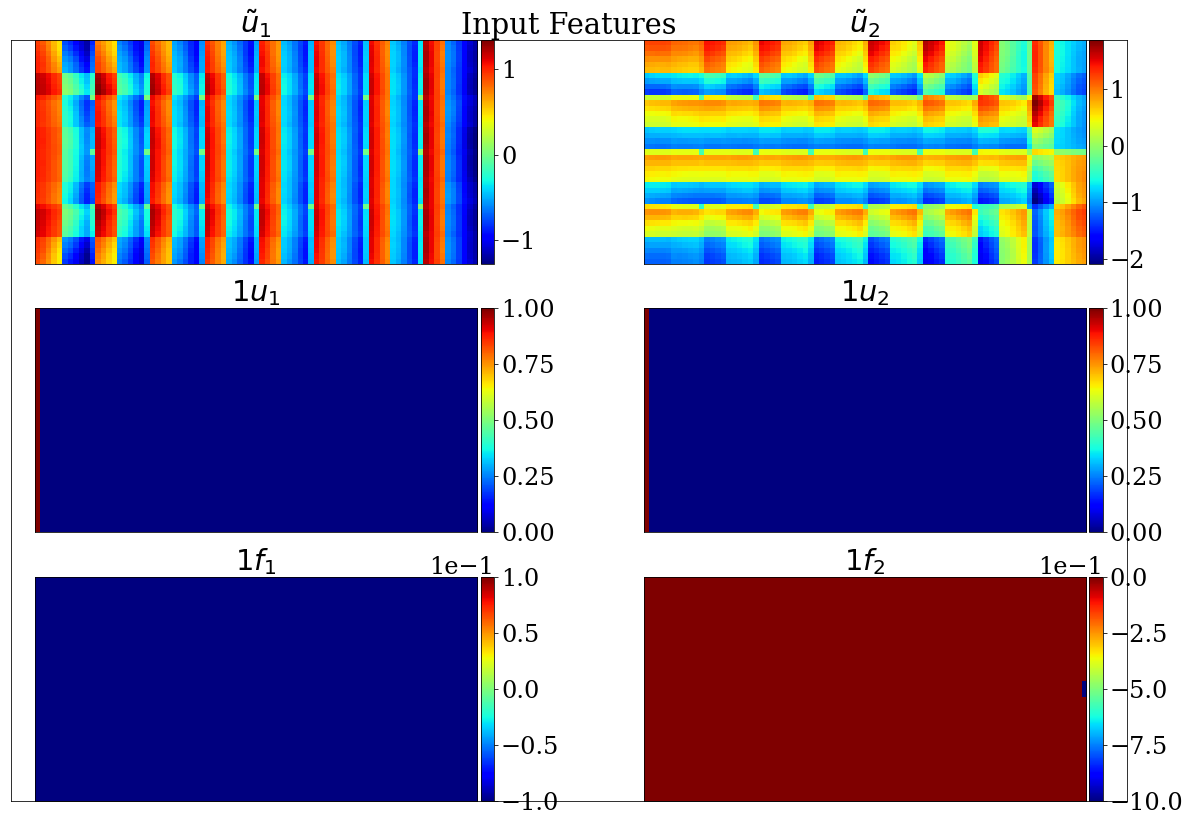

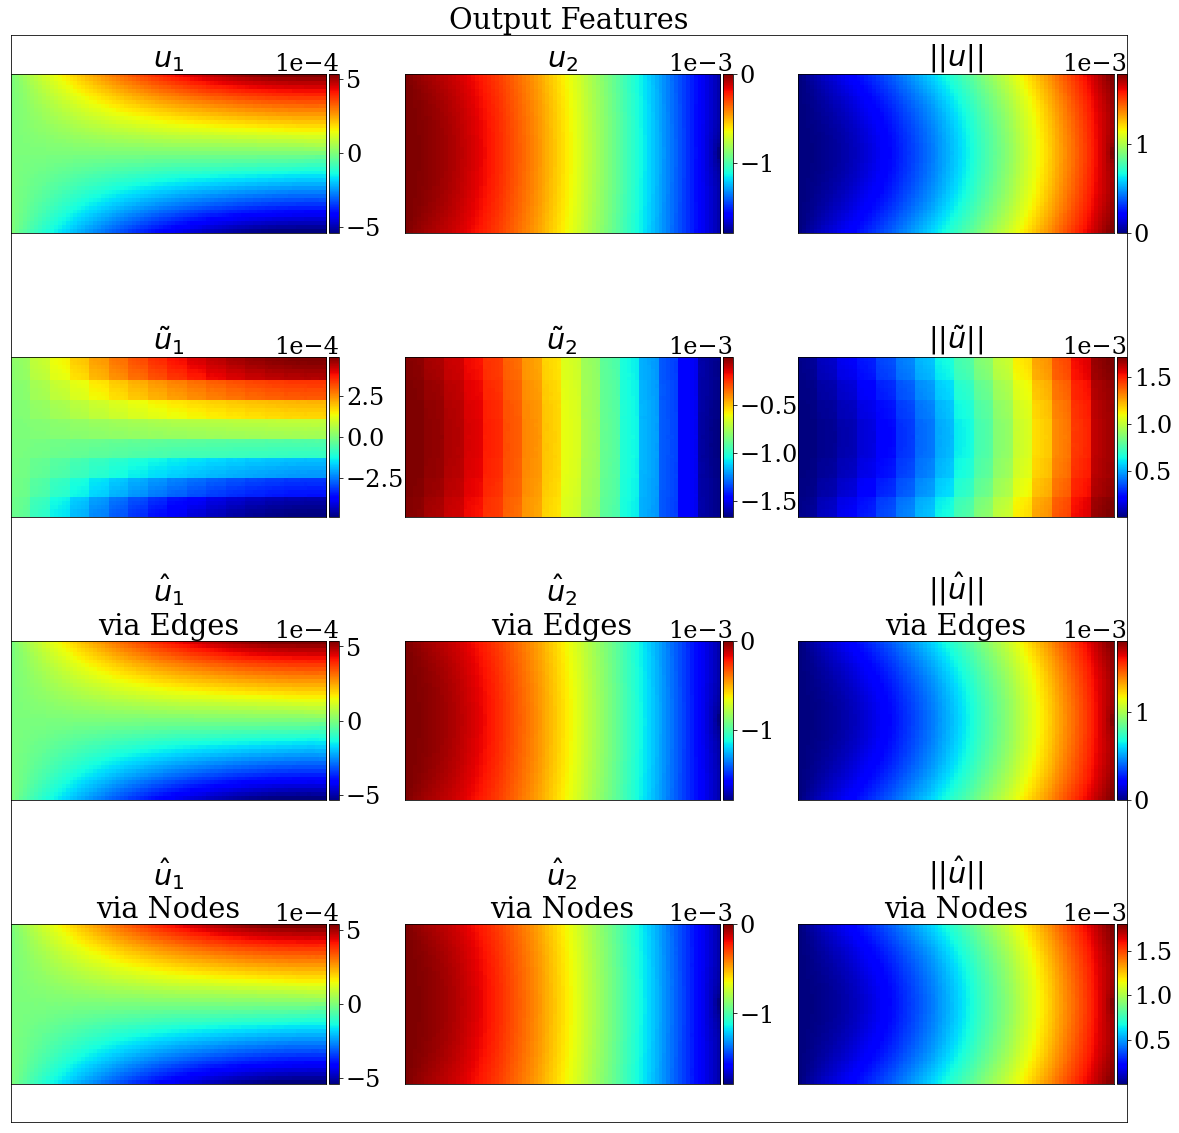

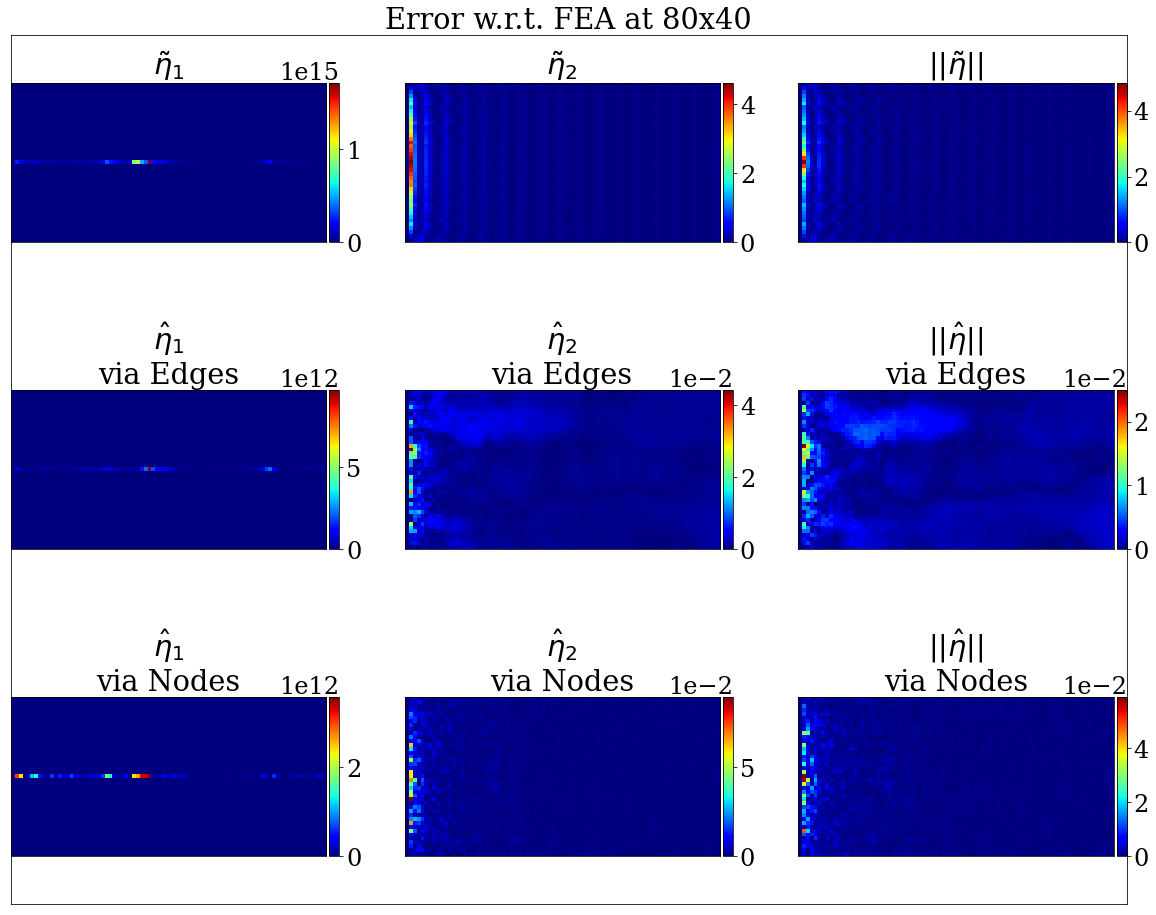

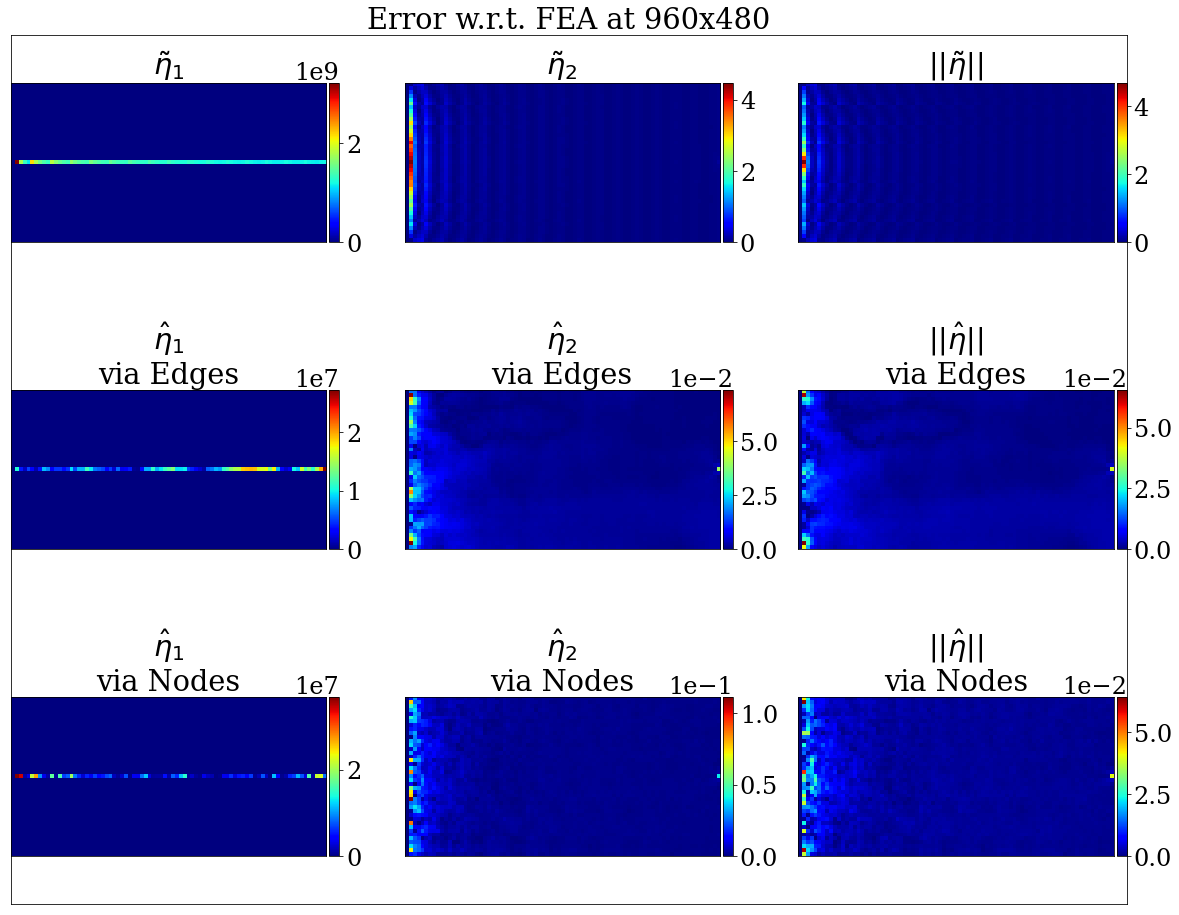

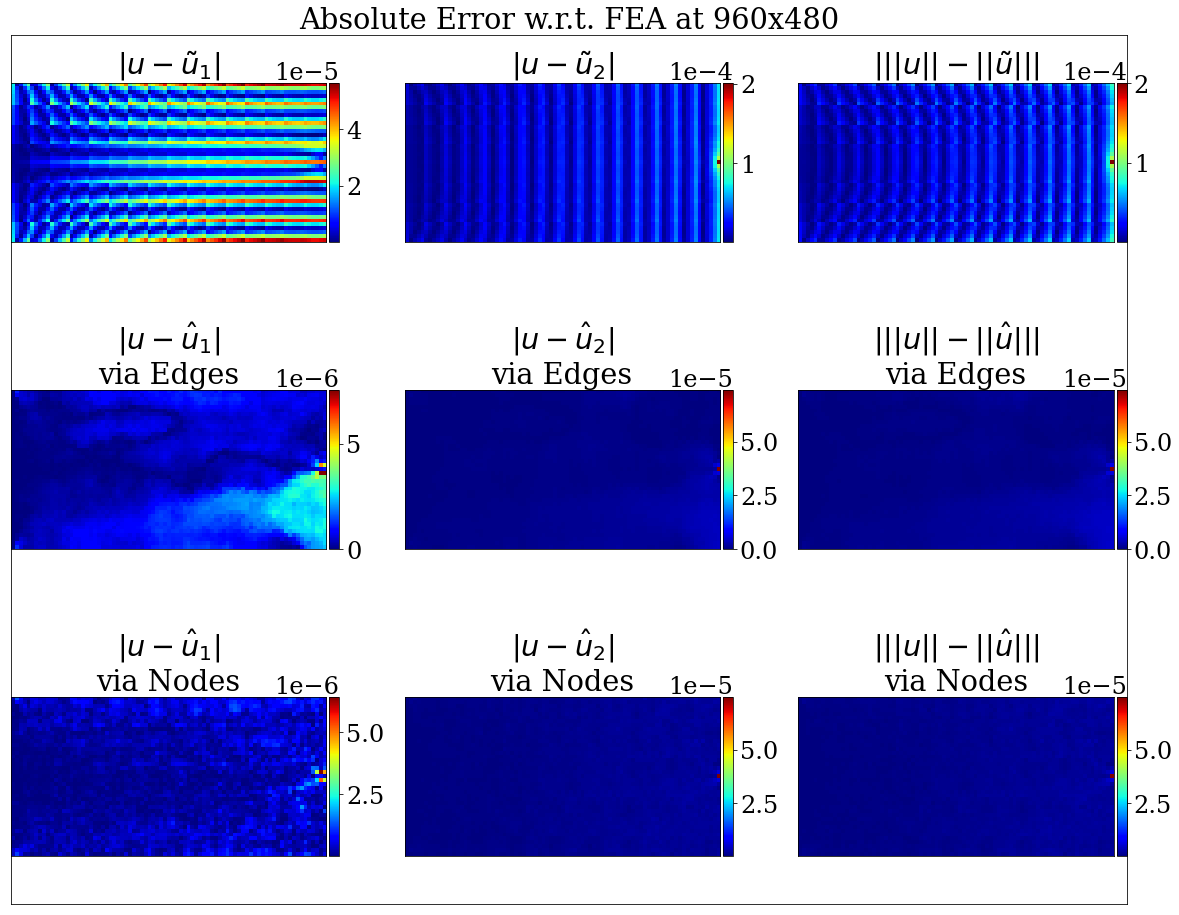

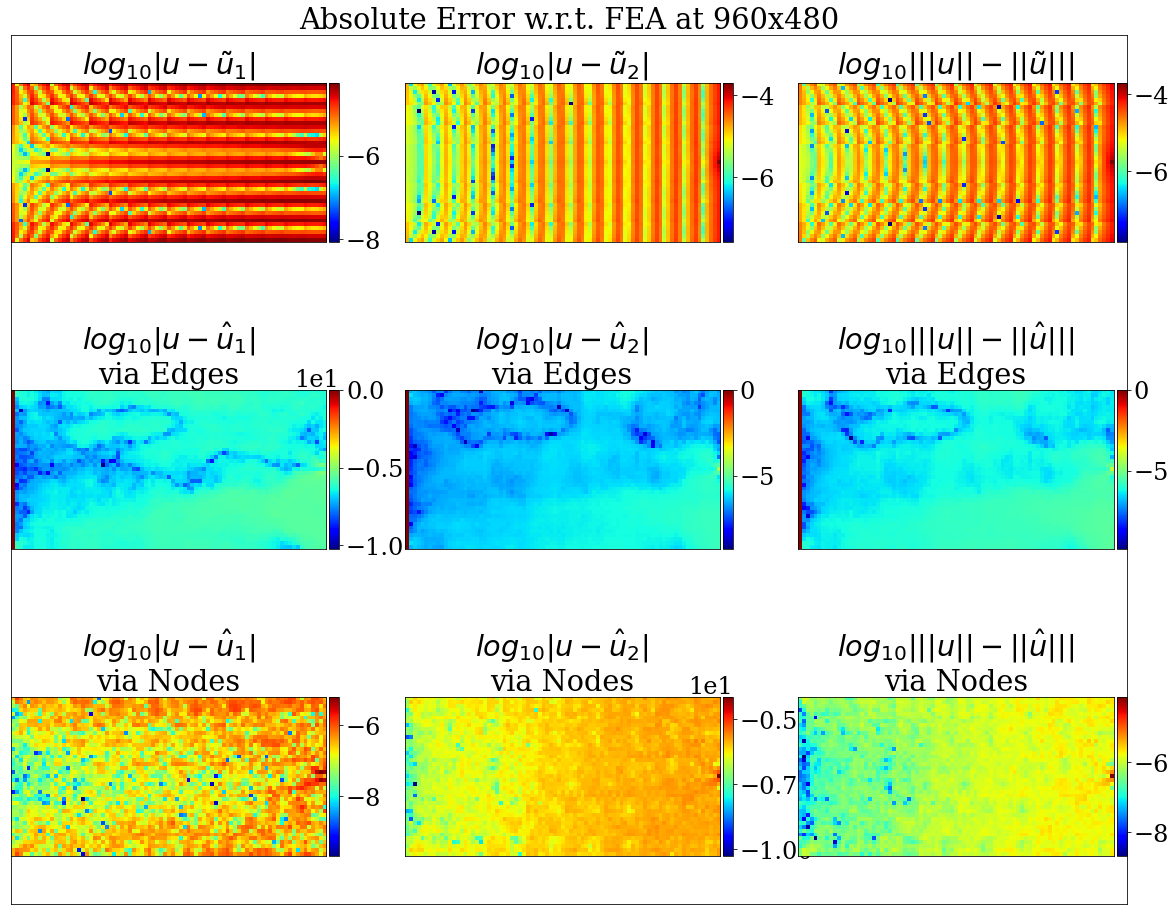

In [15]:
#@title Exececute Visualization


from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_colors(inp, colormap =plt.cm.jet,
               color_min = None, color_max = None):
  """
  interpolates a colormap for the input inp
  """
  if color_min == None :
    vmin = np.min(inp)
  else :
    vmin = color_min
  if color_max == None :
    vmax = np.max(inp)
  else :
    vmax = color_max

  norm = plt.Normalize(vmin, vmax)
  return norm, colormap(norm(inp))

def plot_as_img(ax, attr, m1, m2, 
      title = " ",
      cmap = "jet",
      cmin = None, cmax = None) :
  """
  Given an matplotlib ax, a nodal attribute, and nodal grid dimensions,
  produce a 2d plot of the nodal attribute. 
  """
  if cmap == "jet" :
    plt_cm = plt.cm.jet
  elif cmap == "binary" :
    plt_cm = plt.cm.binary

  if cmin is None :
    cmin = np.amin(attr)
  if cmax is None :
    cmax = np.amax(attr)
 
  norm, color_array = get_colors(attr, colormap = plt_cm, 
                                  color_min = cmin, color_max = cmax)


  ax.set_yticks([])
  ax.set_xticks([])
  ax.set_title(title)
  im = plt.imshow(attr.reshape(m2, m1), cmap = cmap, origin = 'lower',
      vmin = cmin, vmax = cmax)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.05)
  cb2 = mpl.colorbar.ColorbarBase(cax, cmap=plt_cm, norm=norm,) 
  cb2.formatter.set_powerlimits((0, 0))
  #plt.colorbar(im, cax=cax)
  

def plot_inputs( input_nodes, m1, m2, cmap = "jet",
      cmin = None, cmax = None)  :
  """
  Plot each nodal feature from the input graph nodes
  """
  if multi_fidelity_opt : # need to rearrage nodal inputs (for convenience)
    plot_nodes = np.hstack([input_nodes[:,6:8], input_nodes[:,0:4]])
  elif model_selection == "GNN_1.1^U" :
    plot_nodes = np.hstack([input_nodes[:,6:8], input_nodes[:,2:6]])
  else :
    plot_nodes = input_nodes
  
  fig = plt.figure(1, figsize=(20, 14))
  plt.title("Input Features")
  plt.yticks([])
  plt.xticks([])
  titles = [r'$\tilde{u}_1$',  r'$\tilde{u}_2$', 
            r'$1u_1$', r'$1u_2$', 
            r'$1f_1$', r'$1f_2$', ]
  for i in range(len(titles)) :
    ax = fig.add_subplot(3, 2, i+1)
    plot_as_img(ax, plot_nodes[:, i], M1+1, M2+1, title = titles[i], 
                cmap = cmap,
      cmin = cmin, cmax = cmax)

  plt.show()
  fig.clf()

def plot_outputs(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
                 m1, m2, cmap = "jet",
                 cmin = None, cmax = None)  :
  """
  Plot the displacement results, comparing FEA, the initial projection,
  the ML model via edges, and the ML model via nodes
  """
  fig = plt.figure(1, figsize=(20, 20))
  plt.title("Output Features")
  plt.yticks([])
  plt.xticks([])
  titles = [r'$u_1$', r'$u_2$', r'$||u||$',
            r'$\tilde{u}_1$',  r'$\tilde{u}_2$', r'$||\tilde{u}||$',
            r'$\hat{u}_1$'+'\nvia Edges', r'$\hat{u}_2$'+'\nvia Edges', r'$||\hat{u}||$'+'\nvia Edges',
            r'$\hat{u}_1$'+'\nvia Nodes', r'$\hat{u}_2$'+'\nvia Nodes', r'$||\hat{u}||$'+'\nvia Nodes',]
  
  plot_iter = 1
  for disp in [fea_uur_nodes, projection_uur, ml_edges, ml_nodes] :
    
    disp = np.vstack([disp[:,0], disp[:,1], np.linalg.norm(disp, axis = 1)]).T
    for i in range(3) :
      ax = fig.add_subplot(4, 3, plot_iter + i)
      plot_as_img(ax, disp[:, i], M1+1, M2+1, title = titles[plot_iter + i-1], 
                  cmap = cmap,
        cmin = cmin, cmax = cmax)
    plot_iter += 3
   
  plt.show()
  fig.clf()

def plot_error(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
                 m1, m2, cmap = "jet",
                 cmin = None, cmax = None, title_mod = None)  :
  """
  Plot the relative error of the displacement results, comparing FEA, the initial projection,
  the ML model via edges, and the ML model via nodes
  """
  fig = plt.figure(1, figsize=(20, 16))
  if title_mod :
    plt.title(title_mod)
  else :
    plt.title("Error w.r.t. FEA at {}x{}".format(m1-1,m2-1))
  plt.yticks([])
  plt.xticks([])
  titles = [r'$\tilde{\eta}_1$',  r'$\tilde{\eta}_2$', r'$||\tilde{\eta}||$',
            r'$\hat{\eta}_1$'+'\nvia Edges', r'$\hat{\eta}_2$'+'\nvia Edges', r'$||\hat{\eta}||$'+'\nvia Edges',
            r'$\hat{\eta}_1$'+'\nvia Nodes', r'$\hat{\eta}_2$'+'\nvia Nodes', r'$||\hat{\eta}||$'+'\nvia Nodes',]
  
  plot_iter = 1
  fea_uur_nodes = np.vstack([fea_uur_nodes[:,0], fea_uur_nodes[:,1], np.linalg.norm(fea_uur_nodes, axis = 1)]).T
  for disp in [projection_uur, ml_edges, ml_nodes] :
    
    disp = np.vstack([disp[:,0], disp[:,1], np.linalg.norm(disp, axis = 1)]).T
    for i in range(3) :
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        error = np.nan_to_num(np.abs((fea_uur_nodes[:, i]-disp[:, i]) /fea_uur_nodes[:, i]),
                           posinf = 0, neginf =0)   
      ax = fig.add_subplot(3, 3, plot_iter + i)
      plot_as_img(ax, error, M1+1, M2+1, title = titles[plot_iter + i-1], 
                  cmap = cmap,
        cmin = cmin, cmax = cmax)
    plot_iter += 3
   
  plt.show()
  fig.clf()

def plot_l1error(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
                 m1, m2, cmap = "jet",
                 cmin = None, cmax = None, title_mod = None)  :
  """
  Plot the relative error of the displacement results, comparing FEA, the initial projection,
  the ML model via edges, and the ML model via nodes
  """
  fig = plt.figure(1, figsize=(20, 16))
  if title_mod :
    plt.title(title_mod)
  else :
    plt.title("Absolute Error w.r.t. FEA at {}x{}".format(m1-1,m2-1))
  plt.yticks([])
  plt.xticks([])
  titles = [r'$|u-\tilde{u}_1|$',  r'$|u-\tilde{u}_2|$', r'$| ||u|| - ||\tilde{u}|| |$',
            r'$|u-\hat{u}_1|$'+'\nvia Edges', r'$|u-\hat{u}_2|$'+'\nvia Edges', r'$| ||u|| - ||\hat{u}|| |$'+'\nvia Edges',
            r'$|u-\hat{u}_1|$'+'\nvia Nodes', r'$|u-\hat{u}_2|$'+'\nvia Nodes', r'$| ||u|| - ||\hat{u}|| |$'+'\nvia Nodes',]
  
  plot_iter = 1
  fea_uur_nodes = np.vstack([fea_uur_nodes[:,0], fea_uur_nodes[:,1], np.linalg.norm(fea_uur_nodes, axis = 1)]).T
  for disp in [projection_uur, ml_edges, ml_nodes] :
    
    disp = np.vstack([disp[:,0], disp[:,1], np.linalg.norm(disp, axis = 1)]).T
    for i in range(3) :
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        error = np.abs(fea_uur_nodes[:, i]-disp[:, i])
      ax = fig.add_subplot(3, 3, plot_iter + i)
      plot_as_img(ax, error, M1+1, M2+1, title = titles[plot_iter + i-1], 
                  cmap = cmap,
        cmin = cmin, cmax = cmax)
    plot_iter += 3
   
  plt.show()
  fig.clf()

def plot_l1log10error(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
                 m1, m2, cmap = "jet",
                 cmin = None, cmax = None, title_mod = None)  :
  """
  Plot the relative error of the displacement results, comparing FEA, the initial projection,
  the ML model via edges, and the ML model via nodes
  """
  fig = plt.figure(1, figsize=(20, 16))
  if title_mod :
    plt.title(title_mod)
  else :
    plt.title("Absolute Error w.r.t. FEA at {}x{}".format(m1-1,m2-1))
  plt.yticks([])
  plt.xticks([])
  titles = [r'$log_{10}|u-\tilde{u}_1|$',  r'$log_{10}|u-\tilde{u}_2|$', r'$log_{10}| ||u|| - ||\tilde{u}|| |$',
            r'$log_{10}|u-\hat{u}_1|$'+'\nvia Edges', r'$log_{10}|u-\hat{u}_2|$'+'\nvia Edges', r'$log_{10}| ||u|| - ||\hat{u}|| |$'+'\nvia Edges',
            r'$log_{10}|u-\hat{u}_1|$'+'\nvia Nodes', r'$log_{10}|u-\hat{u}_2|$'+'\nvia Nodes', r'$log_{10}| ||u|| - ||\hat{u}|| |$'+'\nvia Nodes',]
  
  plot_iter = 1
  fea_uur_nodes = np.vstack([fea_uur_nodes[:,0], fea_uur_nodes[:,1], np.linalg.norm(fea_uur_nodes, axis = 1)]).T
  for disp in [projection_uur, ml_edges, ml_nodes] :
    
    disp = np.vstack([disp[:,0], disp[:,1], np.linalg.norm(disp, axis = 1)]).T
    for i in range(3) :
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        error = np.nan_to_num(np.log10(np.abs(fea_uur_nodes[:, i]-disp[:, i])),
                              posinf = 0, neginf =0)  
      ax = fig.add_subplot(3, 3, plot_iter + i)
      plot_as_img(ax, error, M1+1, M2+1, title = titles[plot_iter + i-1], 
                  cmap = cmap,
        cmin = cmin, cmax = cmax)
    plot_iter += 3
   
  plt.show()
  fig.clf()

if multi_fidelity_opt :
  # Assemble a complete representation from many different subgraphs
  father_idx = 0
  num_father_elems = m1*m2
  graph_recovery_tst = copy.deepcopy(graph_recovery)
  local_means_tst = copy.deepcopy(local_means_tr)
  local_stds_tst = copy.deepcopy(local_stds_tr)
  local_edge_means_tst = copy.deepcopy(local_edge_means_tr)
  local_edge_stds_tst = copy.deepcopy(local_edge_stds_tr)
  input_graph_tst = copy.deepcopy(input_graph_tr)
  target_tst = copy.deepcopy(target_tr)
  raw_tst = copy.deepcopy(raw_tr)

  fea_sub_graph_list = graph_recovery[father_idx][0]
  graph_nodes = graph_recovery[father_idx][1]
  graph_edges = graph_recovery[father_idx][2]

  loss_sub_graph_list = copy.deepcopy(fea_sub_graph_list)
  model_sub_graph_list = []
  input_sub_graph_list = []
  target_sub_graph_list = []
  conv_list = []
  for i in range(len(fea_sub_graph_list)) :
    data_idx = i + father_idx*num_father_elems
    feed_dict_2_ge = create_feed_dict(data_idx, input_graph_tr, target_tr, local_means_tr, local_stds_tr, local_edge_means_tr, local_edge_stds_tr,
                                initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
    test_values = sess.run({
          "inputs" : initial_conditions_ph,
          "target": true_deformation_ph,
          "loss": loss_ops_tr,
          "outputs": output_ops_tr
          }, feed_dict = feed_dict_2_ge)
    output_ops = test_values["outputs"]
    target_op = target_tr[data_idx]
    
    x_norm = (target_op.nodes[..., 0:1] - local_means_tst[data_idx][0]) /  (local_stds_tst[data_idx][0])
    y_norm = (target_op.nodes[..., 1:2] - local_means_tst[data_idx][1]) / (local_stds_tst[data_idx][1])
    SE_x = ((output_ops[0][..., 0:1] - x_norm)**2)
    SE_y = ((output_ops[0][..., 1:2] - y_norm)**2)
    
    loss_sub_graph_list[i]["nodes"] = np.concatenate([x_norm, y_norm, SE_x, SE_y], axis = 1)

    input_sub_graph_list.append(test_values["inputs"])
    target_sub_graph_list.append(test_values["target"])
    model_sub_graph_list.append(test_values["outputs"])

  target_nodes, target_edges = recover_system_nodes_edges(
      "target", fea_sub_graph_list, graph_nodes, graph_edges, local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                                  local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
  target_receivers, target_senders = return_senders_receivers(fea_sub_graph_list, graph_nodes, graph_edges)

  input_nodes, input_edges = recover_system_nodes_edges("input", input_sub_graph_list, graph_nodes, graph_edges, 
                                                              local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                              local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
  model_nodes, model_edges = recover_system_nodes_edges("model", model_sub_graph_list, graph_nodes, graph_edges, 
                                                              local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                              local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
  raw_nodes, raw_edges = recover_system_nodes_edges("model_raw", model_sub_graph_list, graph_nodes, graph_edges, 
                                                          local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                              local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
  loss_nodes, _ = recover_system_nodes_edges("loss", loss_sub_graph_list, graph_nodes, graph_edges, 
                                                  local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                              local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
  projection_nodes, projection_edges = recover_system_nodes_edges("projection", input_sub_graph_list, graph_nodes, graph_edges, 
                                                        local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                              local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])

  input_gt = graphs.GraphsTuple(nodes=input_nodes,
            edges=input_edges,
            globals=[],
            receivers=list([int(val) for val in target_receivers]),
            senders=list([int(val) for val in target_senders]),
            n_node=[],
            n_edge=[])

  fea_uur_nodes = get_node_trajectories(target_nodes,1, 0, 2)[0]
  projection_uur = projection_nodes[..., 0:2]
  ml_edges = uur_from_edges(input_gt, (model_nodes, model_edges[..., 0:2]),  [[0]*2, [1]*2]*2)
  ml_nodes = get_node_trajectories(model_nodes,1, 0,2)[0]

else :
  # perform global operations
  feed_dict =  create_feed_dict(0, input_graph_tr, target_tr,
                                initial_conditions_ph, true_deformation_ph)
  test_values = sess.run({
        "target": true_deformation_ph,
        "outputs": output_ops_tr
        }, feed_dict = feed_dict)
  fea_uur_nodes = get_node_trajectories(test_values["target"].nodes,1, 0, 2)[0]
  ml_edges = uur_from_edges(input_graph_tr[0], test_values["outputs"],  target_stats)
  ml_nodes = uur_from_nodes(test_values["target"], test_values["outputs"], target_stats)
  input_nodes = input_graph_tr[0].nodes


# Error analysis
err_proj, avg_err_proj, max_proj, min_proj = get_disp_err(fea_uur_nodes, projection_uur)
print("Projection Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_proj, max_proj, min_proj))

err_tst_edges, avg_err_tst, max_tst, min_tst = get_disp_err(fea_uur_nodes, ml_edges)
print("MS Edge Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))

err_tst_nodes, avg_err_tst, max_tst, min_tst = get_disp_err(fea_uur_nodes, ml_nodes)
print("MS Node Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))

plot_inputs(input_nodes, M1+1, M2+1)

plot_outputs(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
             M1+1, M2+1)

plot_error(fea_uur_nodes, projection_uur, ml_edges, ml_nodes, 
             M1+1, M2+1)
if  qualifies_for_convergence_study:
  with open('{}/Documents_Records/uur_known_960x480'.format(PATH), 'rb') as f :
    uur_known = dill.load(f)
  uur_b = project_known_displacement(960, 480, M1, M2, uur_known)
  plot_error(uur_b, projection_uur, ml_edges, ml_nodes, 
             M1+1, M2+1, title_mod = "Error w.r.t. FEA at 960x480")
  plot_l1error(uur_b, projection_uur, ml_edges, ml_nodes, 
             M1+1, M2+1, title_mod = "Absolute Error w.r.t. FEA at 960x480")
  plot_l1log10error(uur_b, projection_uur, ml_edges, ml_nodes, 
             M1+1, M2+1, title_mod = "Absolute Error w.r.t. FEA at 960x480")
else :
  pass

